---
title: "many models workflows in python ii"
subtitle: |
  a tidymodels workflow in python using list columns in pandas dataframes, now with hyperparameter sweep and parallelism
date: "2021-03-28"
date-modified: "2024-04-06"
jupyter: manymodels
categories: [python, workflow, tidymodels]
execute: 
    enabled: false
---

In this followup to [my earlier post](../2020-08-25_many-models-workflows-in-python-part-i/) on modeling workflows in Python, I demonstrate how to integrate sample splitting, parallel processing, exception handling and caching into many-models workflows. I also discuss some differences between exploration/inference-centric workflows and tuning-centric workflows.

## Motivating example

We will work with the [Palmer Penguin](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-28) dataset, which contains various biological measures on three species of penguins. Our goal will be to cluster the penguins into groups that correspond to their species using their bill length, bill depth, flipper length and body mass. We'll use a Gaussian Mixture Model for clustering. Caveat: my goal here is to demonstrate a workflow, not good science.

We'll start by pulling the data into Python and taking a look.

In [1]:
#| column: body-outset
import pandas as pd

penguins = pd.read_csv('https://tinyurl.com/palmerpenguincsv').dropna()

clustering_features = [
    'bill_length_mm',
    'bill_depth_mm',
    'flipper_length_mm',
    'body_mass_g'
]

penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Our next step is to define a helper function to fit GMM estimators for us. I'm going to use `sklearn`'s [GMM implementation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html), which uses the EM algorithm for estimation. The estimator has two key hyperparameters that we'll want to explore:

1. `n_components`: the number of clusters to find
2. `covariance_type`: the assumed structure of the covariances of each cluster

Nothing in the code turns on these hyperparameters dramatically, but it probably worth reading the documentation linked above if haven't seen GMMs before.


In [2]:
from typing import List
from sklearn.mixture import GaussianMixture

# some comments:
# 
# 1. I highly recommend using type hints, since it'll help you keep
#   keep track of what's happening in each column of the eventual
#   data frame of models
#
# 2. Passing hyperparameters as keyword arguments is a generally usefu
#   pattern that make it easy to swap out estimators without having
#   to modify a lot of code that relies on estimators having
#   particular hyperparameters.
#
# 3. Here I specify the columns of the data to use for modeling by
#   passing a list of column names. This is extremely limited and
#   will result in technical debt if you need to do any sort of 
#   interesting work to build a design matrix. Alternatives here
#   might be a list of sklearn Transformers or a Patsy formula.
#   In R you would use a formula object or perhaps a recipe
#   from the recipes packages.
#

def fit_gmm(
    train : pd.DataFrame,
    features : List[chr],
    **hyperparameters
) -> GaussianMixture:
    
    # the hyperparameters are: n_components: int, covariance_type: str
    gmm = GaussianMixture(
        **hyperparameters,
        n_init=5,
        random_state=27
    )
    
    gmm.fit(train[features])
    return gmm

fit_gmm(
    penguins,
    features=clustering_features,
    n_components=3,
    covariance_type='full'
)

GaussianMixture(n_components=3, n_init=5, random_state=27)

Now let's build some infrastructure so that we can use sample splitting to evaluate how well our models perform out of sample. My approach below is heavily inspired by [rsample](https://rsample.tidymodels.org/). At the end of this post I have some longer commentary about this choice and why I haven't used `sklearn` built-in resampling infrastructure.

In [3]:
import numpy as np

class VFoldCV:
    
    def __init__(self, data : pd.DataFrame, num_folds : int = 10):
        
        self.data = data
        self.num_folds = num_folds
        permuted_indices = np.random.permutation(len(data))
        self.indices = np.array_split(permuted_indices, num_folds)
        
    def __iter__(self):
        for test_indices in self.indices:
            test = self.data.iloc[test_indices]
            train = self.data[~self.data.index.isin(test_indices)]
            yield train, test

resamples = VFoldCV(penguins, num_folds=5)

for fold_index, (train, test) in enumerate(resamples):
    print(f"Fold {fold_index} has {len(train)} train and {len(test)} test observations.")

Fold 0 has 270 train and 67 test observations.
Fold 1 has 271 train and 67 test observations.
Fold 2 has 266 train and 67 test observations.
Fold 3 has 269 train and 66 test observations.
Fold 4 has 267 train and 66 test observations.


Now that we have cross validation folds, we want to create a grid of parameters to explore over. Here we leverage `sklearn`'s [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) object, which basically takes a Cartesian product that we can iterate over, as well as coerce to a data frame.


In [4]:
#| column: body-outset
from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid({
    'n_components': range(2, 11),
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
})

model_grid = pd.DataFrame(param_grid)
model_grid.head()

,covariance_type,n_components
0,full,2
1,full,3
2,full,4
3,full,5
4,full,6


Now we are going to do something a little tricky. We are going to create a new column of `model_grid` that contains the results from fitting a GMM to each split from the CV object. In particular, each element in this column will itself be a list with `num_folds` elements. That is, we will create a list-column `cv_fits` were each element of `model_grid.cv_fits` is itself a list. To work with these structures it is easiest to define a helper function that fits a GMM to each CV split for a single combination of hyperparameters. 


In [5]:
#| column: body-outset
def fit_gmm_vfold(
    folds: VFoldCV, 
    **hyperparameters
) -> List[GaussianMixture]:
    
    fits = [
        fit_gmm(train, **hyperparameters)
        for train, test in folds 
    ]
    return fits

model_grid['cv_fits'] = [
    fit_gmm_vfold(
        resamples,
        features=clustering_features,
        **hyperparameters
    )
    for hyperparameters in param_grid
]

model_grid.head()

,covariance_type,n_components,cv_fits
0,full,2,"[GaussianMixture(n_components=2, n_init=5, ran..."
1,full,3,"[GaussianMixture(n_components=3, n_init=5, ran..."
2,full,4,"[GaussianMixture(n_components=4, n_init=5, ran..."
3,full,5,"[GaussianMixture(n_components=5, n_init=5, ran..."
4,full,6,"[GaussianMixture(n_components=6, n_init=5, ran..."


**Note**: To get our cross validated fits, we iterated over `param_grid` and stored results in `model_grid`. It's essential that the row indices match up between these objects. Here they match by construction, but be careful if you start to play with this structure. For example, one alternative (and frequently convenient approach) here is to create a `model_grid` object based on `itertools.product(param_grid, resamples)` rather than just `param_grid`. This avoids nesting lists in list-columns, at the cost of inefficiency in terms of storage. This route is more fiddly than it looks.

Anyway, now that we have training fits, we want to compute out of sample performance estimates. In our case, we'll use a measure of clustering quality known at the Adjusted Rand Score. Again we use nested list comprehensions to get out of sample estimates for all CV splits.


In [6]:
#| column: body-outset
from sklearn.metrics import adjusted_rand_score

def oos_vfold_ars(
    folds: VFoldCV, 
    fits: List[GaussianMixture],
    features : List[chr]
) -> List[float]:
    
    ars = [
        adjusted_rand_score(
            test.species.astype('category').values.codes,
            fit.predict(test[features])
        ) for (_, test), fit in zip(folds, fits)
    ]
    
    return ars

model_grid['cv_ars'] = [
    oos_vfold_ars(
        resamples, 
        fits, 
        features=clustering_features
    )
    for fits in model_grid.cv_fits
]

model_grid.head()

,covariance_type,n_components,cv_fits,cv_ars
0,full,2,"[GaussianMixture(n_components=2, n_init=5, ran...","[0.5726395102425241, 0.7288130378654839, 0.698..."
1,full,3,"[GaussianMixture(n_components=3, n_init=5, ran...","[0.649795918367347, 0.9329634346006913, 0.5982..."
2,full,4,"[GaussianMixture(n_components=4, n_init=5, ran...","[0.6707317073170732, 0.8937422131303624, 0.558..."
3,full,5,"[GaussianMixture(n_components=5, n_init=5, ran...","[0.7274229074889867, 0.7612614063237019, 0.569..."
4,full,6,"[GaussianMixture(n_components=6, n_init=5, ran...","[0.5393957058194889, 0.7891269379827188, 0.764..."


Now we can compare models by expanding the `cv_ars` column and comparing out of sample performance measures. Here I'm just going to visualize the results, but you could also fit a mixed model of the form `adjusted_rand_index ~ hyperparameter_combination + (1|cv_fold)` or something along those lines if you want to be fancier.

It's worth pausing a moment to comment on the `cv_ars` column. In my previous post, I introduced a helper function `unnest()` that you can use to expand a list-column that contains data frames. That `unnest()` function does not work with list-columns of lists, and instead we use the `pandas.Series.explode()` method, which is like an extremely limited version of `tidyr::unnest()`. Importantly, `pandas.Series.explode()` is not very clever about types, so you may need to coerce types after expanding list columns, as I do below.


In [7]:
cross_validated_ars = (
    model_grid
    .explode('cv_ars')
)

print(cross_validated_ars.dtypes, '\n')

cross_validated_ars['covariance_type'] = cross_validated_ars['covariance_type'].astype('string')
cross_validated_ars["cv_ars"] = pd.to_numeric(cross_validated_ars["cv_ars"])

print(cross_validated_ars.dtypes)

covariance_type    object
n_components        int64
cv_fits            object
cv_ars             object
dtype: object 

covariance_type    string[python]
n_components                int64
cv_fits                    object
cv_ars                    float64
dtype: object


Now that we have numeric data we can plot it.

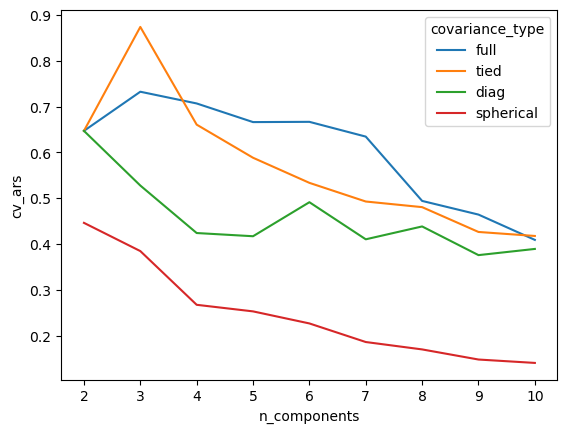

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# using a context manager here to suppress some warnings about
# seaborn using soon-to-be deprecated pandas behavior
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plot = sns.lineplot(
        data=cross_validated_ars[['n_components', 'cv_ars', 'covariance_type']],
        x='n_components', y='cv_ars',
        hue='covariance_type', errorbar=None
    )

    plt.show()

Higher Adjusted Rand Scores are better, so this initial pass of modeling suggests that we should use three clusters. This is reassuring, since we know there are three species of penguin in the dataset!

Note that I'm taking a very informal approach to model selection here and a real analysis should be more careful (in slightly more detail: the difference between CV for model selection and CV for risk estimation is germane here).

There are other approaches to model selection that we could take. For example, we could compare across hyperparameters with in-sample BIC, which is the approach taken in the R package `mclust`. We'll do this briefly for illustrative purposes, and start incorporating some fancier tools along the way:

1. **Parallelization**  (via `joblib`): Modeling fitting across hyperparameter is embarassingly parallel, so this will make things faster.

2. **Exception handling** (via a function decorator): In practice, lots of estimators will run into numerical or data issues that you can safely ignore. In particular, when model fitting fails, it's usually fine to just return a `np.nan` (in R, an `NA`-like object) and use the results from whatever estimators did succeed, propagating the `np.nan` forward.

3. **Caching** (via `joblib`): In interactive workflows it's easy to kill your Jupyter kernel or crash your computer or do something dumb that forces you to restart your Python session. It is really frustrating to have to refit your models everytime this happens. Caching models to disk (also known as memoization) prevents you from having to re-run all your models everytime you break Jupyter, etc, etc. If you use caching, you will have to be careful about cache invalidation, which is one of the most notoriously difficult problems in computing.

See the `joblib` [documentation](https://joblib.readthedocs.io/en/latest/auto_examples/nested_parallel_memory.html#sphx-glr-auto-examples-nested-parallel-memory-py) for more examples of how to combine parallel mapping with caching.

In [9]:
from joblib import Parallel, delayed  # parallelism
from functools import wraps           # nicer exception handling
from joblib import Memory             # caching

# setup caching
cache_dir = "./model_cache"
memory = Memory(cache_dir, verbose=0)

# NOTE: here `n_components` will exceed the number
# of observations for some hyperparameter combinations
# which will cause errors. here i'm artificially introducing
# errors; in real life you'll have to supply your own

fancy_param_grid = ParameterGrid({
    'n_components': range(2, 400),
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
})

fancy_model_grid = pd.DataFrame(fancy_param_grid)
fancy_model_grid.tail()

,covariance_type,n_components
1587,spherical,395
1588,spherical,396
1589,spherical,397
1590,spherical,398
1591,spherical,399


Now we define our function decorator for handling exceptions in list comprehensions. I'm basically copying [`purrr::safely()`](https://purrr.tidyverse.org/reference/safely.html) from R here. Exception handling is essential because it's painful when you fit 9 out of 10 models using a list-comprehension, and then the final model fails and you have to re-run the first 9 models (caching also helps with this when you can get it to work).


In [10]:
def safely(func, otherwise=np.nan):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            return otherwise
    return wrapper

# if bad models become np.nan, downstream calls that use models
# need to handle np.nan input. any easy way to do this is use
# @safely again to just continue propagate np.nan in the
# downstream functions/methods, as in get_bic() below

@safely
def get_bic(fit):
    return fit.bic(penguins[clustering_features])
    
fit_safely = safely(fit_gmm)

# to combine parallelism and caching, use something like:
fit_cached = memory.cache(fit_safely)

# create persistent pool of workers and use them for fitting
with Parallel(n_jobs=10) as parallel:
    
    fancy_model_grid['fit'] = parallel(
        delayed(fit_cached)(penguins, clustering_features, **hyperparameters)
        for hyperparameters in fancy_param_grid
    )
    
    fancy_model_grid['bic'] = parallel(
        delayed(get_bic)(fit) for fit in fancy_model_grid.fit
    )

Now we can compare BIC across our absurdly large number of models. `seaborn` will automatically drop `np.nan()` values, so our `@safely` approach plays very nice here.


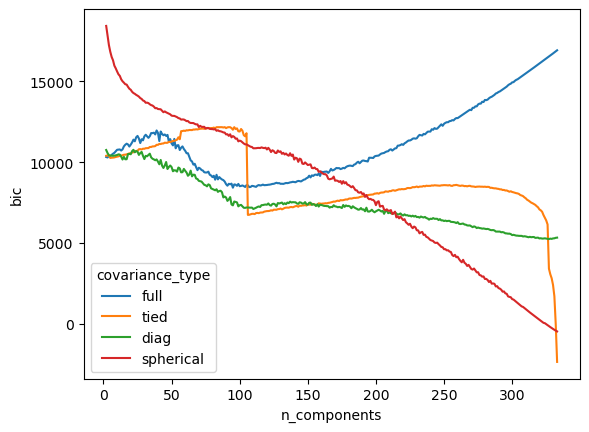

In [11]:
# more seaborn <-> pandas deprecation warning suppression for
# cleaner output
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plot = sns.lineplot(
        data=fancy_model_grid,
        x='n_components', y='bic', hue='covariance_type'
    )

    plt.show()

In this plot lower BIC is better. We see than this in-sample approach to model selection prefers models with as many clusters as observations for most covariance specifications. This would clearly correspond to overfitting in our case.

## Returning to the big picture

At this point, you might be starting to wonderful why you would want to use a many-models workflow at all. All I've done in this blog post is some grid searching over hyperparameters, and we could easily recreate everything in this blog post with `GridSearchCV` and some custom scoring functions.

The problem is that `GridSeachCV` (and other related implementations) are not that flexible. Last summer, I had (1) custom data splitting, (2) custom estimators, and (3) wanted to compute high dimensional summaries for each model I fit. And I want to save my fits so that I could investigate them individually, rather than throwing them out as soon as I know about their predictive performance. `GridSearchCV` just can't handle this, and, by and large, the data science ecosystem in Python doesn't either.

We can imagine that there are two contrasting modeling workflows. First, there's a many-models workflow, which is especially appropriate for research, inference and sensitivity analysis. It's interactive, and not particularly focused on computational efficiency. Then, there's a hyperparameter tuning workflow, which has a simple goal: predict well. Tools for tuning workflows are typically developed by machine learners who  want to train models as computationally efficiently as possible. Because these practitioners emphasize prediction accuracy over all else, it can be hard to re-purpose tools for tuning workflows to learn about models beyond their predictive accuracy[^tidymodels_aside].

Hopefully this post highlights some design patterns you can use when existing infrastructure isn't a good fit for your Python modeling needs. I'm curious to hear about other approaches people take!

[^tidymodels_aside]: **Aside about `tidymodels`**: Early work in the `tidymodels` ecosystem focused on low level infrastructure that facilitated many-models workflows. I still use this infrastructure a lot, especially combined with [`targets`](https://docs.ropensci.org/targets/), which is a `make` variant for R that plays nicely with modeling workflows, and `tidymodels` inspired much of the approach I took in the post above. However, current work in the `tidymodels` ecosystem focuses on high level infrastructure for tuning hyperparameters in predictive modeling scenarios. This mixture of general purpose low level infrastructure and more prediction specific high level infrastructure leads to some interesting discussions like [this one](https://community.rstudio.com/t/mixed-effect-models-and-anova-in-the-tidyverse/48029), where someone asks how to use `tidymodels` to analyze designed experiments, which `tidymodels` [doesn't really provide any tools for](https://community.rstudio.com/t/mixed-effect-models-and-anova-in-the-tidyverse/48029/7?u=alexpghayes).